In [216]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, binary_closing, ball, disk, erosion, dilation   # function for post-processing (size filter)
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import get_middle_frame, get_3dseed_from_mid_frame
from skimage import transform, measure
import h5py
from tqdm import tqdm
from pandas import DataFrame
import pandas as pd
import warnings
import h5py
from skimage.segmentation import watershed
from skimage.morphology import dilation, ball
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt
from aicssegmentation.core.utils import hole_filling
import trackpy as tp
from skimage.segmentation import clear_border

In [183]:
FILE_NAME = "Z://Niethammer Lab//Joe//Research Project//Cell Swelling Experiment//20201120 Cell Swelling Experiment//A549 14 15 Equilibrium Calcium Hypo//20201120 A549 14 15 Ca Equilibrium 600 nm Free Ca  Hypo 003_19.hdf5"
f = h5py.File(FILE_NAME, 'r')

image = f['561 Channel'][:]


In [4]:
import napari
%gui qt

In [14]:
viewer = napari.Viewer()
viewer.add_image(image, scale = [3.4,1,1],colormap='red')

<Image layer 'image' at 0x29e2a508>

In [184]:
image_bg = image_smoothing_gaussian_3d(image,sigma=10)
smooth_image = image_smoothing_gaussian_3d(image,sigma=1)
DOG_Image = smooth_image - image_bg


In [187]:
DOG_Image_Max = np.max(DOG_Image, axis = 1)[0]

In [188]:
print(DOG_Image_Max.shape)

(512, 512)


In [189]:
from cellpose import models, io

In [190]:
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='nuclei')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
masks, flows, styles, diams = model.eval([DOG_Image_Max], diameter=None, channels=channels)


>>>> using CPU
cellpose_residual_on_style_on_concatenation_off
processing 1 image(s)
time spent: running network 3.13s; flow+mask computation 0.00
time spent: running network 1.43s; flow+mask computation 0.44
estimated cell diameters for 1 image(s) in 5.25 sec
time spent: running network 1.84s; flow+mask computation 0.16
estimated masks for 1 image(s) in 2.01 sec
>>>> TOTAL TIME 7.27 sec


In [267]:
msk = masks[0]

msk = clear_border(msk)
msk = remove_small_objects(msk, min_size=400, connectivity=1, in_place=False)
msk = hole_filling(msk, 1, 2000, fill_2d=True)
msk = label(msk)

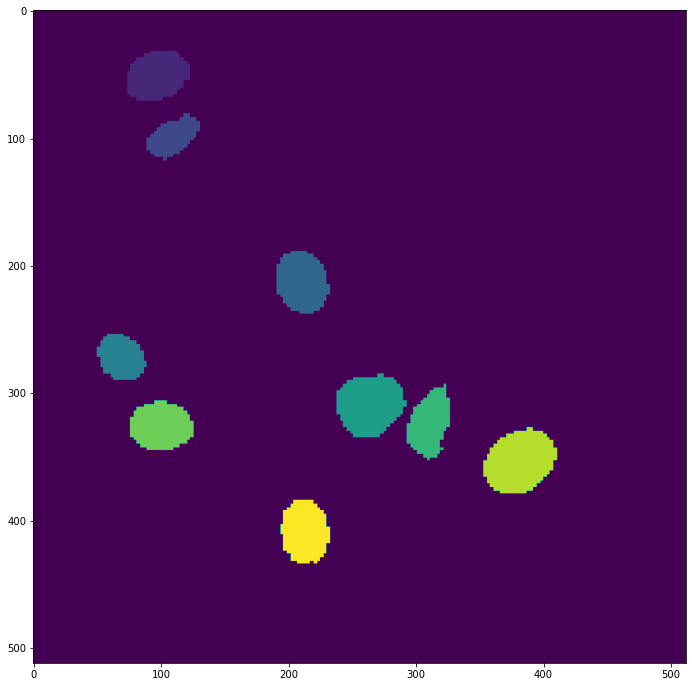

In [268]:
plt.imshow(msk)

In [269]:

region = regionprops(msk)

(512, 512)


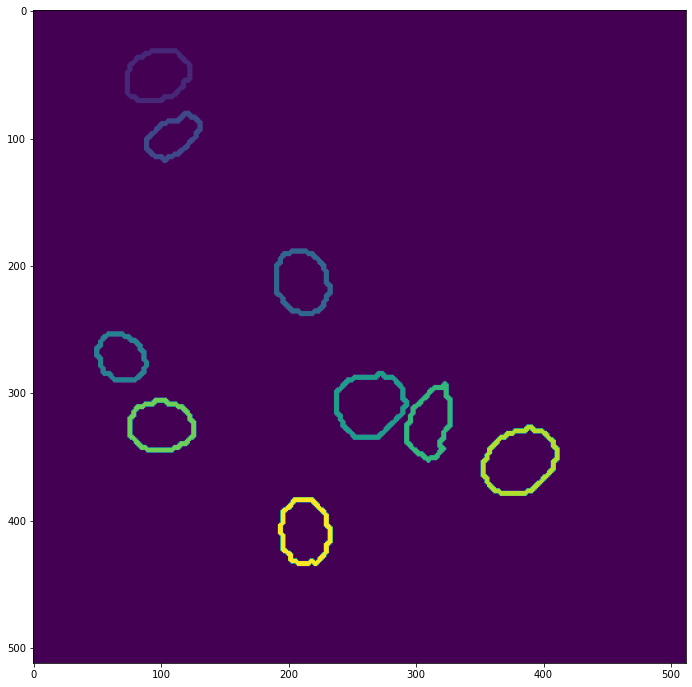

In [270]:
segmented_image_shell_final = np.zeros(msk.shape)
center_list = []
intensity_ratio_list = []
intensity_list = []
intensity_bg_list = []
n = 1
smooth_image_max = np.max(smooth_image,axis = 1)[0]
print(smooth_image_max.shape)
for r in region:
    l = r.label
    img = msk == l
    
    y = r.centroid[0]
    x = r.centroid[1]
    
    center_list.append((y,x))
    
    segmented_image_shell = np.logical_xor(dilation(img, selem=disk(2)),erosion(img, selem=disk(2)))
    
    intensity_median = np.max(smooth_image_max[segmented_image_shell==True])

    intensity_background = np.max(smooth_image_max[int(y),int(x)])
    
    intensity_list.append(intensity_median)
    
    intensity_bg_list.append(intensity_background)
    
    intensity_median_ratio = intensity_median / intensity_background
    
    intensity_ratio_list.append(intensity_median_ratio)
    segmented_image_shell_final += segmented_image_shell * n
    
    n += 1
    
plt.imshow(segmented_image_shell_final)    

In [271]:
center_list = np.array(center_list)

In [272]:
intensity_ratio_list

[1.7714777651615796,
 1.309130603128713,
 1.9605343459970155,
 1.1283451407156329,
 1.7809605736180927,
 1.2995333028496934,
 2.1701927196823956,
 1.5684303856269535,
 1.9790089897351635]

In [273]:
properties = {
    'Med': intensity_list,
    'bg': intensity_bg_list,
    'ratio': intensity_ratio_list
}

In [274]:
text_parameters = {
    'text': 'Int: {Med: .4f}\nBg: {bg:.4f}\nRatio: {ratio: .4f}',
    'size': 14,
    'color': 'white',
    'anchor': 'upper_right',
    'translation': [-5, 0]
}

In [275]:
viewer = napari.Viewer()
viewer.add_image(np.max(smooth_image, axis = 1), scale = [3.4,1,1],colormap='red')
#viewer.add_image(DOG_Image, scale = [3.4,1,1],colormap='cyan')
viewer.add_image(DOG_Image_Max,colormap='twilight_shifted')
viewer.add_labels(msk)
viewer.add_labels(segmented_image_shell_final)
pts = viewer.add_points(center_list,face_color = 'white',size=6,edge_color = 'blue',edge_width=2,properties=properties,
        text=text_parameters)

In [276]:
pts.data

array([[ 51.00454545,  97.03181818],
       [212.89721362, 210.55294118],
       [309.24307244, 263.65580943],
       [325.83387411,  99.98831927],
       [353.54397099, 381.17860381],
       [408.66775244, 212.83908795]])

In [277]:
pts.properties

{'Med': array([628.14693313, 805.71724884, 616.92320358, 810.59658204,
        507.03850543, 718.83220936]),
 'bg': array([354.58922798, 410.96818859, 346.39913579, 373.51363991,
        323.27766031, 363.2283699 ]),
 'ratio': array([1.77147777, 1.96053435, 1.78096057, 2.17019272, 1.56843039,
        1.97900899])}

In [278]:
df = pd.DataFrame(pts.properties)

In [279]:
df

,Med,bg,ratio
0,628.146933,354.589228,1.771478
1,805.717249,410.968189,1.960534
2,616.923204,346.399136,1.780961
3,810.596582,373.513640,2.170193
4,507.038505,323.277660,1.568430
5,718.832209,363.228370,1.979009
